In [45]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats as stats

In [46]:
fluence = pd.read_csv('reinserted_thermal_fluence.csv')

In [47]:
fluence

,# timestamp,cesium_val_0,cesium_val_1,cesium_val_2,cesium_val_3,cesium_val_4,cesium_val_5,cesium_val_6,cesium_val_7,cesium_val_8,...,fluence_val_803,fluence_val_804,fluence_val_805,fluence_val_806,fluence_val_807,fluence_val_808,fluence_val_809,fluence_val_810,fluence_val_811,fluence_val_812
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,3.474796e-08,1.707146e-07,7.250270e-07,1.518698e-07,2.655534e-07,1.096870e-07,4.931048e-07,5.913665e-08,7.028061e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.246938e-06,2.872698e-06,2.737213e-06,3.099643e-06,2.319968e-06,2.971253e-06,4.813968e-07,1.661822e-06,3.443706e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.538420e-06,4.424400e-06,3.635429e-06,5.124641e-06,4.557323e-06,5.301739e-06,3.826000e-06,6.284903e-06,5.364588e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,191.0,0.000000e+00,5.054584e-05,5.790360e-05,4.756137e-05,0.000000e+00,0.000000e+00,6.990133e-05,0.000000e+00,4.825021e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,192.0,5.011145e-05,8.686642e-05,0.000000e+00,4.515687e-05,0.000000e+00,0.000000e+00,4.304290e-05,4.031293e-05,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,193.0,0.000000e+00,0.000000e+00,4.521334e-05,7.796768e-05,0.000000e+00,4.886403e-05,0.000000e+00,0.000000e+00,6.935493e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,194.0,0.000000e+00,4.109691e-05,0.000000e+00,9.213985e-05,7.296321e-05,0.000000e+00,0.000000e+00,3.900867e-05,4.373237e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
def fluence_bins(fluence, fluence_col_start):
    fluence_only = fluence.iloc[:,fluence_col_start:]
    timestamp = fluence[['# timestamp']]
    fluence_t = pd.concat([timestamp, fluence_only], axis=1)
    # Read data
    Tbl = fluence_t

    # Extract data
    Xvals = Tbl.iloc[:,1:-1].to_numpy()
    Yvals = Tbl.iloc[:,-1].to_numpy()
    timestamps = Tbl.iloc[:,0].to_numpy()
    nRows, nCols = Xvals.shape
    #Xavg = np.mean(Xvals, axis=1)

    # define bins
    binMax = Tbl.max().max()
    binInt = binMax/200
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1

    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    return pd.DataFrame(nCountsX)

In [49]:
def cesium_bins(fluence, fluence_col_start):
    cesium_only = fluence.iloc[:,:fluence_col_start]
    # Read data
    Tbl = cesium_only

    # Extract data
    Xvals = Tbl.iloc[:,1:-1].to_numpy()
    Yvals = Tbl.iloc[:,-1].to_numpy()
    timestamps = Tbl.iloc[:,0].to_numpy()
    nRows, nCols = Xvals.shape
    #Xavg = np.mean(Xvals, axis=1)

    # define bins
    binMax = Tbl.max().max()
    binInt = binMax/200
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1

    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    return pd.DataFrame(nCountsX)

In [50]:
fluence = fluence_bins(fluence, 814)
cesium = cesium_bins(fluence, 814)

In [51]:
fluence

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,778,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,102,161,130,198,200,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,104,0,0,1,67,127,114,178,156,60,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,355,0,0,0,0,0,0,0,0,0,...,3,1,1,2,0,0,0,0,0,0
192,347,0,0,0,0,0,0,0,0,0,...,1,0,1,1,2,0,0,0,0,0
193,344,0,0,0,0,0,0,0,0,0,...,2,0,0,1,2,0,0,0,0,0
194,329,0,0,0,0,0,0,0,0,0,...,2,5,4,2,0,0,1,0,0,0


In [52]:
cesium

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,199,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,199,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,198,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,194,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,192,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,163,27,7,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,164,27,3,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,163,26,9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,165,23,8,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
fluence_t.iloc[1]

# timestamp        1.0
fluence_val_0      0.0
fluence_val_1      0.0
fluence_val_2      0.0
fluence_val_3      0.0
                  ... 
fluence_val_808    0.0
fluence_val_809    0.0
fluence_val_810    0.0
fluence_val_811    0.0
fluence_val_812    0.0
Name: 1, Length: 814, dtype: float64

ValueError: too many values to unpack (expected 2)

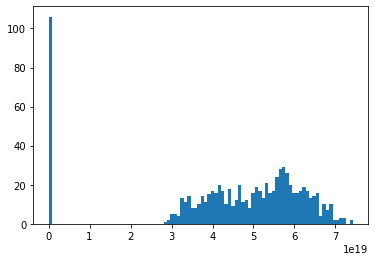

In [31]:
test, test1 = plt.hist(fluence_t.iloc[4], bins = 90)

In [22]:
counts, bin_edges = np.histogram(fluence_t.iloc[100])

In [23]:
counts

array([357,   0,   2, 163,  54,  34,  77,  62,  38,  27])

In [24]:
bin_edges

array([0.00000000e+00, 1.41239125e+20, 2.82478250e+20, 4.23717375e+20,
       5.64956500e+20, 7.06195624e+20, 8.47434749e+20, 9.88673874e+20,
       1.12991300e+21, 1.27115212e+21, 1.41239125e+21])

In [113]:
fluence_t.iloc[:,1:].mean().mean()

4.369526669891298e+20

In [114]:
1.4412777313825236e+21/150

9.608518209216823e+18

In [115]:
fluence_t.iloc[:,:-1].min().min()

0.0

In [116]:
fluence_t=fluence_t.set_index('# timestamp')
row_means = fluence_t.mean(axis=1)
fluence_t = fluence_t.reset_index()

In [117]:
# Read data
Tbl = fluence_t
 
# Extract data
Xvals = Tbl.iloc[:,1:-1].to_numpy()
Yvals = Tbl.iloc[:,-1].to_numpy()
timestamps = Tbl.iloc[:,0].to_numpy()
nRows, nCols = Xvals.shape
#Xavg = np.mean(Xvals, axis=1)
 
# define bins
binMax = 1.4412777313825237e+21
binInt = binMax/200
hEdges = np.arange(0, binMax+binInt, binInt)
nBins = len(hEdges)-1
 
# fill histogram matrix
nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
for n in range(nRows):
    nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    
print(nRows, nBins)

196 201


In [118]:
counts_df = pd.DataFrame(nCountsX)

In [119]:
counts_df

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,778,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,102,161,130,198,200,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,104,0,0,1,67,127,114,178,156,60,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,355,0,0,0,0,0,0,0,0,0,...,3,1,1,2,0,0,0,0,0,0
192,347,0,0,0,0,0,0,0,0,0,...,1,0,1,1,2,0,0,0,0,0
193,344,0,0,0,0,0,0,0,0,0,...,2,0,0,1,2,0,0,0,0,0
194,329,0,0,0,0,0,0,0,0,0,...,2,5,4,2,0,0,1,0,0,0


In [120]:
def bin_names(arr):
    arr_names = []
    for i in range(len(arr)):
        arr[i] = np.format_float_scientific(arr[i], unique=False, precision=2)
        if i+2 > len(arr):
            break
        else:
            arr[i+1] = np.format_float_scientific(arr[i+1], unique=False, precision=2)
            arr_names.append(str([str(arr[i]) + ':' + str(arr[i+1])]))
    return arr_names

hEdges_name = bin_names(hEdges)


In [121]:
timestamp = fluence['# timestamp'].values
counts_df.index = timestamps
counts_df.index.name = 't'
counts_df.columns = hEdges_name
counts_df['means'] = row_means

In [122]:
counts_df.shape

(196, 202)

In [125]:
counts_df.head()

,['0.0:7.21e+18'],['7.21e+18:1.44e+19'],['1.44e+19:2.16e+19'],['2.16e+19:2.88e+19'],['2.88e+19:3.6e+19'],['3.6e+19:4.32e+19'],['4.32e+19:5.04e+19'],['5.04e+19:5.77e+19'],['5.77e+19:6.49e+19'],['6.49e+19:7.21e+19'],...,['1.38e+21:1.39e+21'],['1.39e+21:1.4e+21'],['1.4e+21:1.41e+21'],['1.41e+21:1.41e+21'],['1.41e+21:1.42e+21'],['1.42e+21:1.43e+21'],['1.43e+21:1.43e+21'],['1.43e+21:1.44e+21'],['1.44e+21:1.45e+21'],means
t,,,,,,,,,,,,,,,,,,,,,
0.0,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
1.0,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
2.0,778,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.103589e+18
3.0,102,161,130,198,200,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.049087e+19
4.0,104,0,0,1,67,127,114,178,156,60,...,0,0,0,0,0,0,0,0,0,4.457204e+19


In [126]:
counts_df.to_csv('fluence.csv')

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [ ]:
# define the dataset classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class ReactorData(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        
        self.labels = data.iloc[:, -1:]
        self.data = data.iloc[:, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        ss = StandardScaler()


        self.data = ss.fit_transform(self.data)
        self.labels = mm.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        